In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm

sbn.set()

MISSING

- Warmup needed for Metropolis-Hastings in (1)?

<h3>(1) Metropolis Hastings</h3>

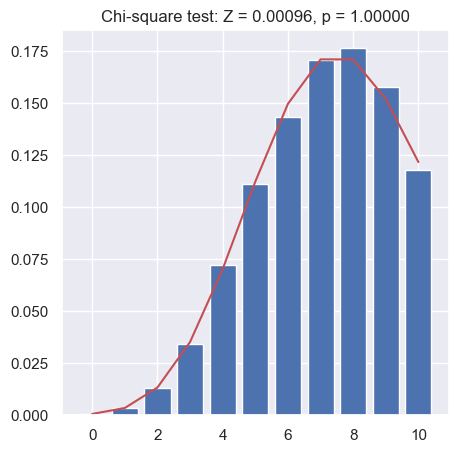

In [30]:
def analytical_solution(A = 8, m = 10):
    var = [g(A, i) for i in range(m)]
    return var / np.sum(var)

def sample_dxi(m):
    U = np.random.randint(-m, m + 1, size = 1)   
    return U
    
def g(A, i):
    return (A ** i) / np.math.factorial(i)

def metropolis_hastings(A, m = 10, n = 10000):
    # Initialize states
    X = np.zeros(n).astype(int)
    i = 0
    j = 0

    X[0] = i

    for j in range(0, n - 1):
        Xi = X[j]

        dXi = sample_dxi(m)

        Y = int(np.mod(Xi + dXi, m + 1)) # Propose to jump to Yi
        
        gy = g(A = A, i = Y)
        gxi = g(A = A, i = Xi)

        if  gy >= gxi:
            accept = True
        else: 

            U = np.random.uniform(0, 1, 1)
            
            if gy / gxi > U:
                accept = True
            else:
                accept = False

        if accept:
            X[j + 1] = Y
        else:
            X[j + 1] = Xi

    return X

m = 10        
A = 8
X = metropolis_hastings(A = A, m = m, n = 10000)

temp =  np.histogram(X, bins = m + 1, density=1)[0] 
X_hist = temp / temp.sum()

P = analytical_solution(m = m + 1)

test = stats.chisquare(X_hist, P)

Z = test.statistic
p = test.pvalue

fig, ax = plt.subplots(1, figsize = (5, 5))
ax.plot(P, color = 'r')
ax.bar(x = np.arange(0, m + 1, 1), height = X_hist)
ax.set_title(f'Chi-square test: Z = {Z:.5f}, p = {p:.5f}')

plt.show()

100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


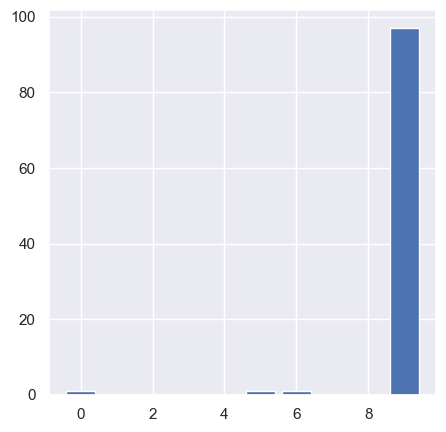

In [27]:
# Calculate p-values for multiple runs
runs = 100
p_vals = np.zeros(runs)

for r in tqdm(range(runs)):
    X = metropolis_hastings(A = A, m = m, n = 10000)

    temp =  np.histogram(X, bins = m + 1, density=0)[0] 
    X_hist = temp / temp.sum()

    P = analytical_solution(m = m + 1)

    test = stats.chisquare(X_hist, P)
    p = test.pvalue

    p_vals[r] = p

p_hist = np.histogram(p_vals, bins = 10)[0]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.bar(x = np.arange(0, 10), height = p_hist)

plt.show()

<h3>(2) Joint occupied lines </h3>

In [12]:
def sample_dx(range_, n = 2):
    U = np.random.randint(-range_, range_ + 1, size = n)   
    return U

def g_joined(A1, A2, i, j):
    return ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))

def metropolis_hastings_joined(A = 8, m = 10, N = 10000, mode = 'ordinary'):
    X = np.zeros((N, 2)).astype(int)
    i = 0
    j = 0

    X[0] = [i, j]

    for n in range(0, N - 1):
        Xn = X[n]

        if mode == 'ordinary':

            proposal_found = False
            while not proposal_found:
                dXn = sample_dx(range_ = m, n = 2)

                Y = np.mod(Xn + dXn, m + 1).astype(int) # Propose to jump to Y

                if Y.sum() <= m:
                    proposal_found = True
            
            gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
            gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

            if  gy >= gx:
                accept = True
            else: 

                U = np.random.uniform(0, 1, 1)
            
                if gy / gx > U:
                    accept = True
                else:
                    accept = False

            if accept:
                X[n + 1] = Y
            else:
                X[n + 1] = Xn

        elif mode == 'coordinatewise':
            Yk = [Xn]
            
            # First acceptance in x-direction, then y-direction
            for k in range(2):
                
                proposal_found = False

                while not proposal_found:
                    dXnk = sample_dx(range_ = m, n = 1)

                    Y = Yk[k].copy() # Get the current state
                    Y[k] += dXnk # Add the state at the coordinate
                    Y = np.mod(Y, m)

                    if Y.sum() <= m:
                        proposal_found = True

                gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
                gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

                if  gy >= gx:
                    accept = True
                else: 
                    U = np.random.uniform(0, 1, 1)
        
                    if gy / gx > U:
                        accept = True
                    else:
                        accept = False

                Yk.append(Y)
            
            X[n] = Y[1]
    return X
    
def analytical_solution_joined(A = [4, 4], m = 10):
    P = np.zeros((m + 1, m + 1))
    A1 = A[0]
    A2 = A[1]

    for i in range(m + 1):
        for j in range(m + 1):
            if (i + j) <= m:
                P[i, j] = ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))


    #var = [g(A, i) for i in range(m)]
    return P / np.sum(P)


X = metropolis_hastings_joined(A = [4, 4], m = 10, N = 10000, mode = 'coordinatewise')
P = analytical_solution_joined(A = [4, 4], m = 10)

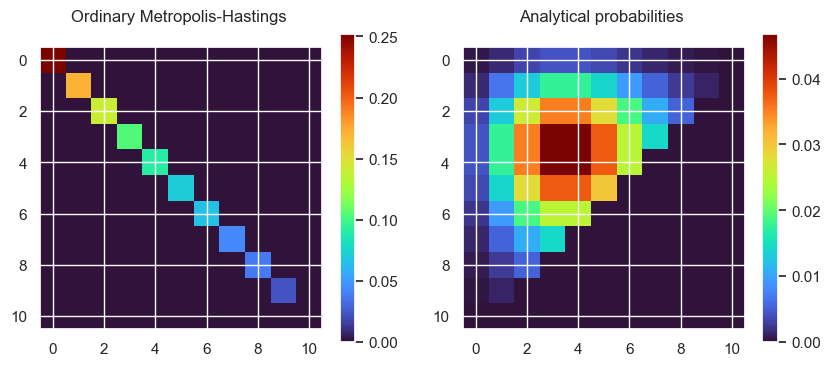

In [13]:
X = metropolis_hastings_joined(A = [4, 4], m = 10, N = 10000, mode = 'coordinatewise')
temp = np.histogram2d(x = X[:, 0], y = X[:, 1], bins = np.arange(0, m + 2, 1), density=True)[0]
X_hist = temp / temp.sum() # Normalize probabilities

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].set_title(f'Ordinary Metropolis-Hastings \n ')
im1 = ax[0].imshow(X_hist, cmap = 'turbo')
plt.colorbar(im1, ax=ax[0])

ax[1].set_title(f'Analytical probabilities \n')
im2 = ax[1].imshow(P, cmap = 'turbo')
plt.colorbar(im2, ax=ax[1])

plt.show()



In [315]:
P.flatten()

array([0.00041116, 0.00164465, 0.00328931, 0.00438575, 0.00438575,
       0.0035086 , 0.00233906, 0.00133661, 0.0006683 , 0.00029702,
       0.00011881, 0.00164465, 0.00657862, 0.01315724, 0.01754298,
       0.01754298, 0.01403439, 0.00935626, 0.00534643, 0.00267322,
       0.0011881 , 0.        , 0.00328931, 0.01315724, 0.02631448,
       0.03508597, 0.03508597, 0.02806878, 0.01871252, 0.01069287,
       0.00534643, 0.        , 0.        , 0.00438575, 0.01754298,
       0.03508597, 0.04678129, 0.04678129, 0.03742503, 0.02495002,
       0.01425716, 0.        , 0.        , 0.        , 0.00438575,
       0.01754298, 0.03508597, 0.04678129, 0.04678129, 0.03742503,
       0.02495002, 0.        , 0.        , 0.        , 0.        ,
       0.0035086 , 0.01403439, 0.02806878, 0.03742503, 0.03742503,
       0.02994003, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00233906, 0.00935626, 0.01871252, 0.02495002,
       0.02495002, 0.        , 0.        , 0.        , 0.     

X_hist.flatten()